Temat: "Predykcja czasu osiągnięcia odporności zbiorowej w przypadku COVID-19 w grupie Wyszehradzkiej"

Zespół: Blanka Piekarz, Marcin Stachura

In [80]:
import pandas as pd
import numpy as np
import matplotlib as mtl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

df = pd.read_csv('./country_vaccinations.csv', delimiter=',')

columnsToDrop = ['iso_code', 'daily_vaccinations_raw', 'source_website', 'source_name',
                 'vaccines', 'people_fully_vaccinated_per_hundred',
                 'people_vaccinated_per_hundred', 'total_vaccinations_per_hundred']

data = df.drop(columnsToDrop, 1)
data = data[data['daily_vaccinations'].notna()]

#  ---- ADD POPULATION -----
df_population = pd.read_csv("population.csv", delimiter=',', sep=',', header=2, usecols=['Country Name', '2019'])
df_population.loc[df_population['Country Name'] == 'Slovak Republic', 'Country Name'] = 'Slovakia'

for i in range(0,len(df_population)):
    data.loc[data['country'] == df_population.loc[i, 'Country Name'], 'population'] = df_population.loc[i, '2019']

#  ---- VISEGRAD STATISTICS / FILL NaN -----
visegrad_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Czech Republic', 'Hungary', 'Poland', 'Slovakia']
visegrad_data = data[data['country'].isin(visegrad_countries)]
for i in range(0, len(visegrad_countries)):
    visegrad_data.loc[visegrad_data['country'] == visegrad_countries[i], 'country'] = i

visegrad_data = visegrad_data.reset_index(drop=True)

import datetime as dt
visegrad_data['date'] = pd.to_datetime(visegrad_data['date'])

date_column = visegrad_data['date'].copy()
country_column = visegrad_data['country'].copy()

visegrad_data = visegrad_data.fillna(visegrad_data.mean())
visegrad_data

C:\Users\Cinek\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,country,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,daily_vaccinations_per_million,population
0,0,2020-12-28,2031.0,2031.0,390501.215088,1299.0,144.0,8877067.0
1,0,2020-12-29,3651.0,3651.0,390501.215088,1460.0,162.0,8877067.0
2,0,2020-12-30,5003.0,5003.0,390501.215088,1424.0,158.0,8877067.0
3,0,2020-12-31,5011.0,5011.0,390501.215088,1070.0,119.0,8877067.0
4,0,2021-01-01,5015.0,5015.0,390501.215088,857.0,95.0,8877067.0
...,...,...,...,...,...,...,...,...
825,7,2021-04-23,1416394.0,1005369.0,411025.000000,20699.0,3791.0,5454073.0
826,7,2021-04-24,1435414.0,1017808.0,417606.000000,19654.0,3600.0,5454073.0
827,7,2021-04-25,1454256.0,1031049.0,423207.000000,20574.0,3768.0,5454073.0
828,7,2021-04-26,1475587.0,1038023.0,437564.000000,20758.0,3802.0,5454073.0


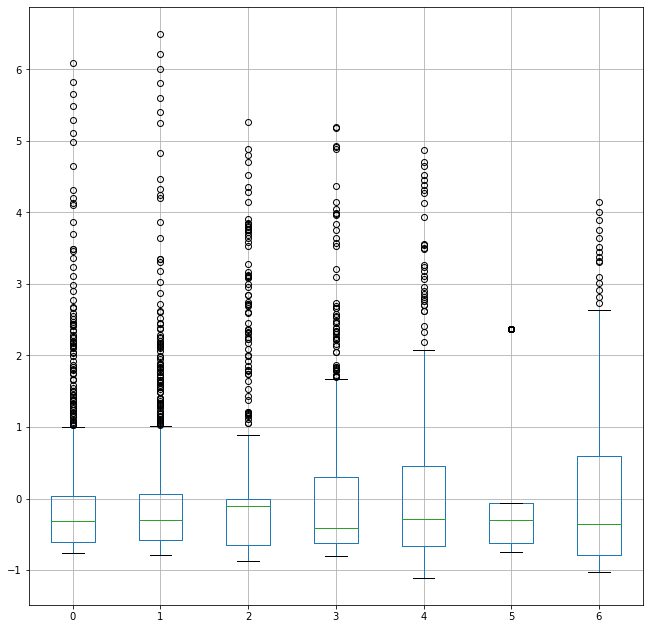

In [81]:
#  ---- STANDARDIZATION ----
visegrad_data['total_vaccinations_percentage'] = visegrad_data['total_vaccinations']/visegrad_data['population']
visegrad_data = visegrad_data.drop(['date'], 1)
visegrad_data = visegrad_data.drop(['country'], 1)


visegrad_values = visegrad_data.values
X_standard_scaler = visegrad_values - visegrad_values.mean(axis=0)
X_standard_scaler = X_standard_scaler / visegrad_values.std(axis=0)

# X_standard_scaler.hist(figsize=(30,30))
dr = pd.DataFrame(X_standard_scaler)
dr.boxplot()

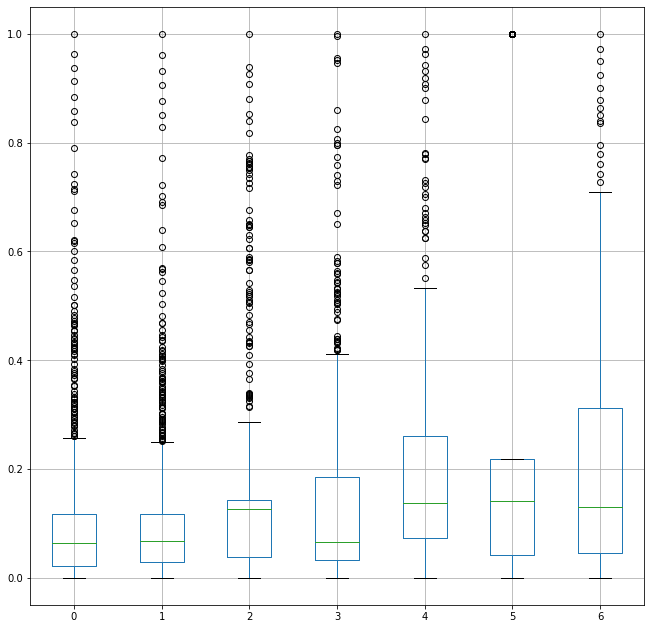

In [82]:
#  ---- STANDARDIZATION - USING SKLEARN ----
from sklearn import preprocessing

values = visegrad_data.values
min_max_scaler = preprocessing.MinMaxScaler()
data_input_scaled = min_max_scaler.fit_transform(values)
df_new = pd.DataFrame(data_input_scaled)

df_new.boxplot()

In [83]:
df_new.describe()

,0,1,2,3,4,5,6
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,0.111108,0.109166,0.142164,0.134717,0.185174,0.238900,0.198752
std,0.146238,0.137261,0.163044,0.166544,0.167504,0.320671,0.193171
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.021435,0.029146,0.037295,0.031720,0.073640,0.040898,0.045549
50%,0.064468,0.067416,0.125680,0.065816,0.137000,0.141861,0.130172
75%,0.116564,0.117462,0.142164,0.184344,0.260260,0.218756,0.312132
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [84]:
from sklearn.model_selection import train_test_split

X = dr.values[:,2:]
y = dr.values[:,-1:]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, shuffle=False)
x_ax = range(len(y_test))

In [85]:
from xgboost import XGBRegressor

xgb_clf = XGBRegressor(objective="reg:squarederror", n_estimators=100)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)

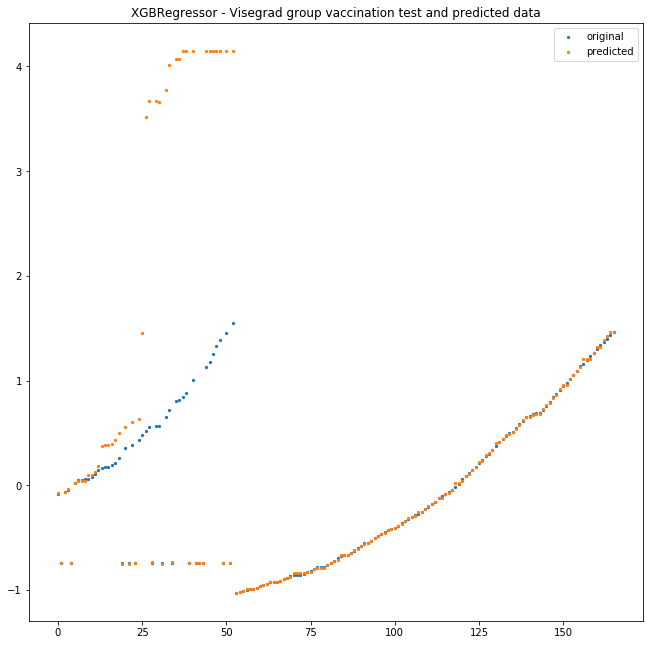

In [86]:
plt.scatter(x_ax, y_test, s=5, label="original")
plt.scatter(x_ax, y_pred_xgb, s=5, label="predicted")
plt.title("XGBRegressor - Visegrad group vaccination test and predicted data")
plt.legend()
plt.show()

In [87]:
from sklearn.svm import SVR

svr_clf = SVR()
svr_clf.fit(X_train, y_train)
y_pred_svr = svr_clf.predict(X_test)

C:\Users\Cinek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


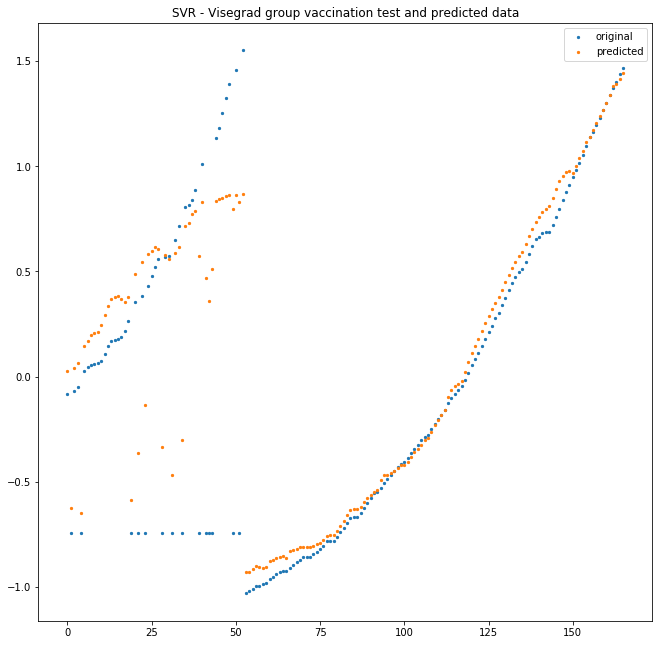

In [88]:
plt.scatter(x_ax, y_test, s=5, label="original")
plt.scatter(x_ax, y_pred_svr, s=5, label="predicted")
plt.title("SVR - Visegrad group vaccination test and predicted data")
plt.legend()
plt.show()

In [89]:
from sklearn.metrics import mean_squared_error

def get_squared_error_score(x, y):
    y_prediction = np.reshape(y, (y.shape[0], -1))
    return mean_squared_error(x, y)

def get_r2_score(x, y):
    y_prediction = np.reshape(y, (y.shape[0], -1))
    zx = (x-np.mean(x))/np.std(x, ddof=1)
    zy = (y_prediction-np.mean(y_prediction))/np.std(y_prediction, ddof=1)
    r = np.sum(zx*zy)/(len(x)-1)
    return r**2

r2_score_xgb = get_r2_score(y_test, y_pred_xgb)
r2_score_svr = get_r2_score(y_test, y_pred_svr)

print(f'XGBRegressor score: {r2_score_xgb}')
print(f'SVR score: {r2_score_svr}')


XGBRegressor score: 0.6499603021629976
SVR score: 0.8544607514382236


In [90]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

time_series_split = TimeSeriesSplit(max_train_size=None, n_splits=10)
i = 0
for train_index, test_index in time_series_split.split(X):
    i += 1
    X_train_cross_validation, X_test_cross_validation = X[train_index], X[test_index]
    y_train_cross_validation, y_test_cross_validation = y[train_index], y[test_index]
    print(f'Iteration: {i}   Train interval: {train_index[0]}-{train_index[-1]}   Test interval: {test_index[0]}-{test_index[-1]}')


Iteration: 1   Train interval: 0-79   Test interval: 80-154
Iteration: 2   Train interval: 0-154   Test interval: 155-229
Iteration: 3   Train interval: 0-229   Test interval: 230-304
Iteration: 4   Train interval: 0-304   Test interval: 305-379
Iteration: 5   Train interval: 0-379   Test interval: 380-454
Iteration: 6   Train interval: 0-454   Test interval: 455-529
Iteration: 7   Train interval: 0-529   Test interval: 530-604
Iteration: 8   Train interval: 0-604   Test interval: 605-679
Iteration: 9   Train interval: 0-679   Test interval: 680-754
Iteration: 10   Train interval: 0-754   Test interval: 755-829


Ponieważ stosujemy szeregi czasowe, przewidywanie przeszłości za pomocą danych z przyszłości wydaje się być bez sensu. Z tego powodu stosujemy dzielenie danych na podzbiory w sposób przedstawiony na ilustracji poniżej:

https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4
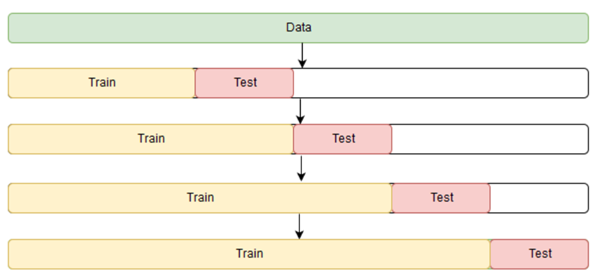

Zastosowanie powyższej walidacji krzyżowej dla poszczególnych regresorów:

In [91]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn import tree
from sklearn import neighbors
from statistics import mean
from IPython.display import HTML, display

def display_table(data):
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td><h4>%s</h4><td>"%(field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))
    

def svr_regression_prediction(X_train, y_train, X_test):
    svr_clf = SVR()
    svr_clf.fit(X_train, y_train)
    y_pred_svr = svr_clf.predict(X_test)
    return y_pred_svr
    
def xgb_regression_prediction(X_train, y_train, X_test):
    xgb_clf = XGBRegressor(objective="reg:squarederror", n_estimators=100)
    xgb_clf.fit(X_train, y_train)
    y_pred_xgb = xgb_clf.predict(X_test)
    return y_pred_xgb

def mlp_regression_prediction(X_train, y_train, X_test):
    mlp_clf = MLPRegressor()
    mlp_clf.fit(X_train, y_train)
    y_pred_mlp = mlp_clf.predict(X_test)
    return y_pred_mlp

def tree_regression_prediction(X_train, y_train, X_test):
    tree_clf = tree.DecisionTreeRegressor()
    tree_clf.fit(X_train, y_train)
    y_pred_tree = tree_clf.predict(X_test)
    return y_pred_tree

def k_neighbors_regression_prediction(X_train, y_train, X_test):
    k_neighbors_clf = neighbors.KNeighborsRegressor()
    k_neighbors_clf.fit(X_train, y_train)
    y_pred_k_neighbors = k_neighbors_clf.predict(X_test)
    return y_pred_k_neighbors

def voting_regression_prediction(X_train, y_train, X_test, clf_1, clf_2, clf_3):
    voting_clf = VotingRegressor([('clf1', clf_1), ('clf2', clf_2), ('clf3', clf_3)], n_jobs=-1)
    voting_clf.fit(X_train, y_train)
    y_pred_voting = voting_clf.predict(X_test)
    return y_pred_voting

def stacking_regression_prediction(X_train, y_train, X_test, clf_1, clf_2, clf_3):
    stacking_clf = StackingRegressor([('clf1', clf_1), ('clf2', clf_2), ('clf3', clf_3)], n_jobs=-1)
    stacking_clf.fit(X_train, y_train)
    y_pred_stacking = stacking_clf.predict(X_test)
    return y_pred_stacking

svr_r2_scores = []
xgb_r2_scores = []
mlp_r2_scores = []
tree_r2_scores = []
k_neighbours_r2_scores = []
svr_squared_scores = []
xgb_squared_scores = []
mlp_squared_scores = []
tree_squared_scores = []
k_neighbours_squared_scores = []
voting_r2_scores = []
voting_squared_scores = []
stacking_r2_scores = []
stacking_squared_scores = []
i = 0
for train_index, test_index in time_series_split.split(X):
    i += 1
    X_train_cross_validation, X_test_cross_validation = X[train_index], X[test_index]
    y_train_cross_validation, y_test_cross_validation = y[train_index], y[test_index]
    
    prediction_svr = svr_regression_prediction(X_train_cross_validation, y_train_cross_validation, X_test_cross_validation)
    r2_score_svr = get_r2_score(y_test_cross_validation, prediction_svr)
    squared_score_svr = get_squared_error_score(y_test_cross_validation, prediction_svr)
    svr_r2_scores.append(r2_score_svr)
    svr_squared_scores.append(squared_score_svr)
    
    prediction_xgb = xgb_regression_prediction(X_train_cross_validation, y_train_cross_validation, X_test_cross_validation)
    r2_score_xgb = get_r2_score(y_test_cross_validation, prediction_xgb)
    squared_score_xgb = get_squared_error_score(y_test_cross_validation, prediction_xgb)
    xgb_r2_scores.append(r2_score_xgb)
    xgb_squared_scores.append(squared_score_xgb)
    
    prediction_mlp = mlp_regression_prediction(X_train_cross_validation, y_train_cross_validation, X_test_cross_validation)
    r2_score_mlp = get_r2_score(y_test_cross_validation, prediction_mlp)
    squared_score_mlp = get_squared_error_score(y_test_cross_validation, prediction_mlp)
    mlp_r2_scores.append(r2_score_mlp)
    mlp_squared_scores.append(squared_score_mlp)
    
    prediction_tree_regression = tree_regression_prediction(X_train_cross_validation, y_train_cross_validation, X_test_cross_validation)
    r2_score_tree_regression = get_r2_score(y_test_cross_validation, prediction_tree_regression)
    squared_score_tree_regression = get_squared_error_score(y_test_cross_validation, prediction_tree_regression)
    tree_r2_scores.append(r2_score_tree_regression)
    tree_squared_scores.append(squared_score_tree_regression)
    
    prediction_k_neighbours = k_neighbors_regression_prediction(X_train_cross_validation, y_train_cross_validation, X_test_cross_validation)
    r2_score_k_neighbours = get_r2_score(y_test_cross_validation, prediction_k_neighbours)
    squared_score_k_neighbours = get_squared_error_score(y_test_cross_validation, prediction_k_neighbours)
    k_neighbours_r2_scores.append(r2_score_k_neighbours)
    k_neighbours_squared_scores.append(squared_score_k_neighbours)
    
    
    #VOTING CLASSIFIER
    xgb_vote_clf = XGBRegressor(objective="reg:squarederror", n_estimators=100)
    mlp_vote_clf = MLPRegressor()
    tree_vote_clf = tree.DecisionTreeRegressor()
    prediction_voting = voting_regression_prediction(X_train_cross_validation, y_train_cross_validation, X_test_cross_validation, xgb_vote_clf, mlp_vote_clf, tree_vote_clf)
    r2_score_voting = get_r2_score(y_test_cross_validation, prediction_voting)
    squared_score_voting = get_squared_error_score(y_test_cross_validation, prediction_voting)
    voting_r2_scores.append(r2_score_voting)
    voting_squared_scores.append(squared_score_voting)
    
    #STACKING CLASSIFIER
    xgb_stack_clf = XGBRegressor(objective="reg:squarederror", n_estimators=100)
    mlp_stack_clf = MLPRegressor()
    tree_stack_clf = tree.DecisionTreeRegressor()
    prediction_stacking = stacking_regression_prediction(X_train_cross_validation, y_train_cross_validation, X_test_cross_validation, xgb_stack_clf, mlp_stack_clf, tree_stack_clf)
    r2_score_stacking = get_r2_score(y_test_cross_validation, prediction_stacking)
    squared_score_stacking = get_squared_error_score(y_test_cross_validation, prediction_stacking)
    stacking_r2_scores.append(r2_score_stacking)
    stacking_squared_scores.append(squared_score_stacking)
    
    

table_data = [['Regressor model', 'Average r2 score', 'Mean Squared Error score']]
table_data.append(['SVR', mean(svr_r2_scores), mean(svr_squared_scores)])
table_data.append(['XGBRegressor', mean(xgb_r2_scores), mean(xgb_squared_scores)])
table_data.append(['MLP', mean(mlp_r2_scores), mean(mlp_squared_scores)])
table_data.append(['Decision Tree', mean(tree_r2_scores), mean(tree_squared_scores)])
table_data.append(['K-neighbours', mean(k_neighbours_r2_scores), mean(k_neighbours_squared_scores)])
table_data.append(['Voting Regressor', mean(voting_r2_scores), mean(voting_squared_scores)])
table_data.append(['Stacking Regressor', mean(stacking_r2_scores), mean(stacking_squared_scores)])

display_table(table_data)




C:\Users\Cinek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Cinek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Cinek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Cinek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

C:\Users\Cinek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Cinek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Cinek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Cinek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

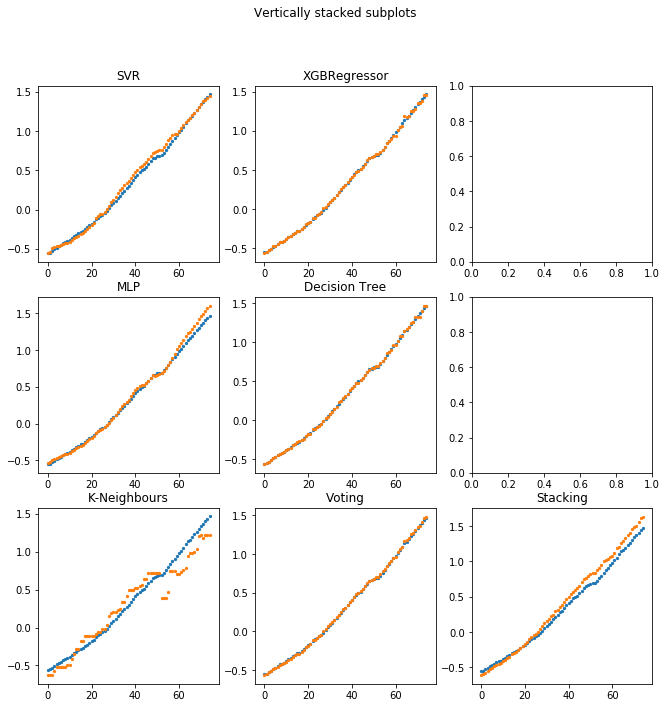

In [92]:
x_ax = range(len(y_test_cross_validation))    
mtl.rcParams['figure.figsize'] = (11,11)
fig, axs = plt.subplots(3, 3)
fig.suptitle('Vertically stacked subplots')
axs[0, 0].set_title('SVR')
axs[0, 0].scatter(x_ax, y_test_cross_validation, s=5)
axs[0, 0].scatter(x_ax, prediction_svr, s=5)
axs[0, 1].set_title('XGBRegressor')
axs[0, 1].scatter(x_ax, y_test_cross_validation, s=5)
axs[0, 1].scatter(x_ax, prediction_xgb, s=5)
axs[1, 0].set_title('MLP')
axs[1, 0].scatter(x_ax, y_test_cross_validation, s=5)
axs[1, 0].scatter(x_ax, prediction_mlp, s=5)
axs[1, 1].set_title('Decision Tree')
axs[1, 1].scatter(x_ax, y_test_cross_validation, s=5)
axs[1, 1].scatter(x_ax, prediction_tree_regression, s=5)
axs[2, 0].set_title('K-Neighbours')
axs[2, 0].scatter(x_ax, y_test_cross_validation, s=5)
axs[2, 0].scatter(x_ax, prediction_k_neighbours, s=5)
axs[2, 1].set_title('Voting')
axs[2, 1].scatter(x_ax, y_test_cross_validation, s=5)
axs[2, 1].scatter(x_ax, prediction_voting, s=5)
axs[2, 2].set_title('Stacking')
axs[2, 2].scatter(x_ax, y_test_cross_validation, s=5)
axs[2, 2].scatter(x_ax, prediction_stacking, s=5)